In [1]:
import heeps
from heeps.util.psf_template import psf_template
from heeps.util.lamD import get_lamD_mas
import numpy as np
import vip_hci
import os.path
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

In [2]:
# max offset value in lam/D
offmax = 30
# number of off-axis points in each direction
npts = 50
# initialize conf
conf = dict(
    dir_output = 'OAT',
    f_pupil = 'pupil/ELT_fullM1.fits',
    ls_ext_circ = False,
    ls_int_circ = False,
    ravc_calc = False,
    add_phase = False,
    add_point_err = True,
    nframes = 2*npts,
)
conf = heeps.config.read_config(verbose=False, **conf)

# 1. L-band RAVC

In [3]:
conf.update(
    band = 'L',
    mode = 'RAVC',
    hfov = 0.8,
    ls_dRext = 0.0477,
    ls_dRint = 0.02,
    ls_dRspi = 0.0249,
)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.2568
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=285, pscale=5.4700 mas, lam=3.8112E-06 m
   hfov=0.8 arcsec (-> ndet=293, 37.62 lam/D)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


### Offsets

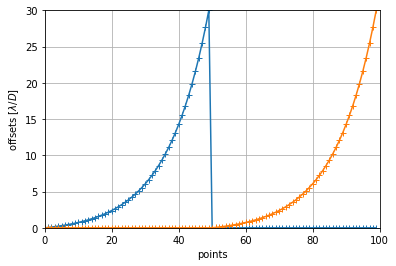

In [4]:
lamD = get_lamD_mas(**conf)
xymax = min(conf['hfov']*1e3/lamD, offmax)
logb = 0.02*xymax
xy = np.logspace(np.log10(logb), np.log10(xymax + logb), npts) - logb
xy = np.float32([(x,0) for x in xy] + [(0,y) for y in xy])
xy_mas = xy*lamD
xy_pix = xy_mas/conf['pscale']

conf['f_point_err'] = os.path.join(conf['dir_output'], 'oat_%s_%s.fits'%(conf['band'], conf['mode']))
fits.writeto(conf['f_point_err'], xy_mas, overwrite=True)

plt.plot(xy, '-+')
plt.xlim(0, len(xy))
plt.ylim(0, xymax)
plt.xlabel('points')
plt.ylabel('offsets [$\lambda/D$]')
plt.grid(True), plt.grid(which='minor', linestyle=':');

### Aperture photometry

Create single off-axis PSF
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
   apply Lyot stop: circ_ext/int=[False, True], ls_dRext/int/spi=[0.0477, 0.02, 0.0249], ls_misalign=None
   extract PSF on the detector: ndet=293
fwhm=3.34pix, ap_flux=7.42e-02

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load pointing errors from 'oat_L_RAVC.fits'
   nscreens=100
Create on-axis PSF cube
   preloading RAVC apodizer, apo_misalign=None
   preloading Lyot stop, ls_misalign=None
   2022-06-13 20:18:37, e2e simulation using 12 cores
   2022-06-13 20:19:22, completed in 45.44 seconds



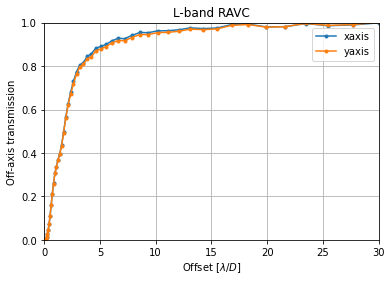

In [5]:
psf_OFF = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=False, verbose=True, **conf)
psf_OFF_crop, fwhm, ap_flux = psf_template(psf_OFF)
print('fwhm=%.2fpix, ap_flux=%.2e\n'%(fwhm, ap_flux))
psfs_ON = heeps.wavefront.propagate(wf, onaxis=True, savefits=True, verbose=True, **conf);
_, ny, nx = psfs_ON.shape
(cx, cy) = nx//2, ny//2
psf_flux = []
for psf, (dx,dy) in zip(psfs_ON, xy_pix):
    psf_flux.append(vip_hci.metrics.aperture_flux(psf, [cy-dy], [cx-dx], fwhm, verbose=False)[0])
psf_flux = np.float32(psf_flux) / ap_flux
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.plot(xy[:npts,0], psf_flux[:npts], '.-', label='xaxis')
plt.plot(xy[npts:,1], psf_flux[npts:], '.-', label='yaxis')
plt.xlim(0, xy[-1,1])
plt.ylim(0, 1)
plt.xlabel('Offset [$\lambda/D$]')
plt.ylabel('Off-axis transmission')
plt.title('L-band RAVC')
plt.legend();

psf_flux_L_RAVC = np.clip((psf_flux[:npts] + psf_flux[npts:])/2, 0, 1)
fits.writeto(conf['f_point_err'], np.float32([xy_pix[:npts,0], psf_flux_L_RAVC]), overwrite=True)

# 2. L-band CVC

In [6]:
conf.update(
    band = 'L',
    mode = 'CVC',
    hfov = 0.8,
    ls_dRext = 0.0209,
    ls_dRint = 0.09,
    ls_dRspi = 0.0245,
)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=285, pscale=5.4700 mas, lam=3.8112E-06 m
   hfov=0.8 arcsec (-> ndet=293, 37.62 lam/D)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


In [7]:
conf['f_point_err'] = os.path.join(conf['dir_output'], 'oat_%s_%s.fits'%(conf['band'], conf['mode']))
fits.writeto(conf['f_point_err'], xy_mas, overwrite=True)

Create single off-axis PSF
   apply Lyot stop: circ_ext/int=[False, False], ls_dRext/int/spi=[0.0209, 0.09, 0.0245], ls_misalign=None
   extract PSF on the detector: ndet=293
fwhm=3.48pix, ap_flux=2.20e-01

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load pointing errors from 'oat_L_CVC.fits'
   nscreens=100
Create on-axis PSF cube
   preloading Lyot stop, ls_misalign=None
   2022-06-13 20:19:25, e2e simulation using 12 cores
   2022-06-13 20:20:12, completed in 46.79 seconds



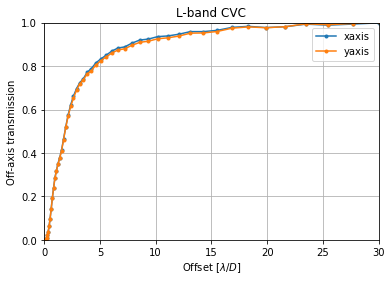

In [8]:
psf_OFF = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=False, verbose=True, **conf)
psf_OFF_crop, fwhm, ap_flux = psf_template(psf_OFF)
print('fwhm=%.2fpix, ap_flux=%.2e\n'%(fwhm, ap_flux))
psfs_ON = heeps.wavefront.propagate(wf, onaxis=True, savefits=True, verbose=True, **conf);
ny, nx = psf_OFF.shape
(cx, cy) = nx//2, ny//2
psf_flux = []
for psf, (dx,dy) in zip(psfs_ON, xy_pix):
    psf_flux.append(vip_hci.metrics.aperture_flux(psf, [cy-dy], [cx-dx], fwhm, verbose=False)[0])
psf_flux = np.float32(psf_flux) / ap_flux
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.plot(xy[:npts,0], psf_flux[:npts], '.-', label='xaxis')
plt.plot(xy[npts:,1], psf_flux[npts:], '.-', label='yaxis')
plt.xlim(0, xy[-1,1])
plt.ylim(0, 1)
plt.xlabel('Offset [$\lambda/D$]')
plt.ylabel('Off-axis transmission')
plt.title('L-band CVC')
plt.legend();

psf_flux_L_CVC = np.clip((psf_flux[:npts] + psf_flux[npts:])/2, 0, 1)
fits.writeto(conf['f_point_err'], np.float32([xy_pix[:npts,0], psf_flux_L_CVC]), overwrite=True)

# 3. N-band CVC

In [9]:
conf.update(
    band = 'N2',
    mode = 'CVC',
    hfov = 2.2,
    ls_dRext = 0.0268,
    ls_dRint = 0.09,
    ls_dRspi = 0.0357,
)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.1072
   npupil=119, pscale=6.7900 mas, lam=1.1330E-05 m
   hfov=2.2 arcsec (-> ndet=649, 34.79 lam/D)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


In [10]:
lamD = get_lamD_mas(**conf)
xymax = min(conf['hfov']*1e3/lamD, offmax)
logb = 0.02*xymax
xy = np.logspace(np.log10(logb), np.log10(xymax + logb), npts) - logb
xy = np.float32([(x,0) for x in xy] + [(0,y) for y in xy])
xy_mas = xy*lamD
xy_pix = xy_mas/conf['pscale']

conf['f_point_err'] = os.path.join(conf['dir_output'], 'oat_%s_%s.fits'%(conf['band'], conf['mode']))
fits.writeto(conf['f_point_err'], xy_mas, overwrite=True)

Create single off-axis PSF
   apply Lyot stop: circ_ext/int=[False, False], ls_dRext/int/spi=[0.0268, 0.09, 0.0357], ls_misalign=None
   extract PSF on the detector: ndet=649
fwhm=8.46pix, ap_flux=2.09e-01

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load pointing errors from 'oat_N2_CVC.fits'
   nscreens=100
Create on-axis PSF cube
   preloading Lyot stop, ls_misalign=None
   2022-06-13 20:20:16, e2e simulation using 12 cores
   2022-06-13 20:21:06, completed in 50.0 seconds



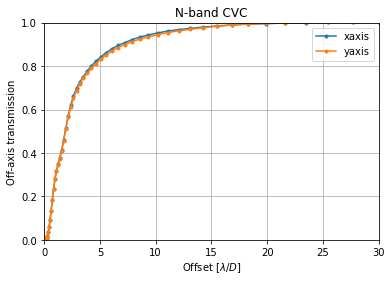

In [11]:
psf_OFF = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=False, verbose=True, **conf)
psf_OFF_crop, fwhm, ap_flux = psf_template(psf_OFF)
print('fwhm=%.2fpix, ap_flux=%.2e\n'%(fwhm, ap_flux))
psfs_ON = heeps.wavefront.propagate(wf, onaxis=True, savefits=True, verbose=True, **conf);
ny, nx = psf_OFF.shape
(cx, cy) = nx//2, ny//2
psf_flux = []
for psf, (dx,dy) in zip(psfs_ON, xy_pix):
    psf_flux.append(vip_hci.metrics.aperture_flux(psf, [cy-dy], [cx-dx], fwhm, verbose=False)[0])
psf_flux = np.float32(psf_flux) / ap_flux
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.plot(xy[:npts,0], psf_flux[:npts], '.-', label='xaxis')
plt.plot(xy[npts:,1], psf_flux[npts:], '.-', label='yaxis')
plt.xlim(0, xy[-1,1])
plt.ylim(0, 1)
plt.xlabel('Offset [$\lambda/D$]')
plt.ylabel('Off-axis transmission')
plt.title('N-band CVC')
plt.legend();

psf_flux_N_CVC = np.clip((psf_flux[:npts] + psf_flux[npts:])/2, 0, 1)
fits.writeto(conf['f_point_err'], np.float32([xy_pix[:npts,0], psf_flux_N_CVC]), overwrite=True)

# 4. All modes

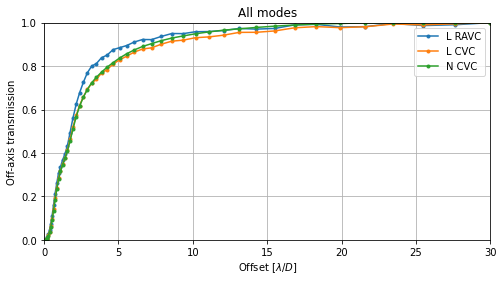

In [12]:
plt.figure(figsize=(8, 4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.plot(xy[:npts,0], psf_flux_L_RAVC, '.-', label='L RAVC')
plt.plot(xy[:npts,0], psf_flux_L_CVC, '.-', label='L CVC')
plt.plot(xy[:npts,0], psf_flux_N_CVC, '.-', label='N CVC')
plt.xlim(0, xy[-1,1])
plt.ylim(0, 1)
plt.xlabel('Offset [$\lambda/D$]')
plt.ylabel('Off-axis transmission')
plt.title('All modes')
plt.legend();